In [1]:
import pandas as pd
from pyxlsb import open_workbook
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Define la ruta al archivo .xlsb
file_path = './BBDD_Scoring.xlsb' 

# Inicializa una lista para almacenar los datos
data = []

# Lee el archivo y extrae las filas
with open_workbook(file_path) as wb:
    with wb.get_sheet(1) as sheet:  # Cambia "1" al índice correcto de la hoja si es necesario
        for row in sheet.rows():
            # Extrae los valores de cada fila
            data.append([item.v for item in row])

# Convierte los datos en un DataFrame
df = pd.DataFrame(data[1:], columns=data[0])  # Usa la primera fila como nombres de columnas

In [3]:
# Calcular número de valores distintos en cada columna
columnas_sin_valores_distintos = df.nunique()[df.nunique() < 2].index
df = df.drop(columnas_sin_valores_distintos, axis=1)

In [4]:
df['saldo_<_30k'] = (df['Saldo_total'] < 30000).astype(int)

# Tabla con porcentaje de cantidad de personas con saldo menor a 30k y default
tabla = df.groupby('default')['saldo_<_30k'].value_counts(normalize=True).unstack()
display(tabla) # significa que el 97% de las personas con saldo menor a 30k han entrado en default y solo el 

tabla2 = df.groupby('saldo_<_30k')['default'].value_counts(normalize=True).unstack()
display(tabla2)

saldo_<_30k,0,1
default,,
0.0,0.189171,0.810829
1.0,0.033505,0.966495


default,0.0,1.0
saldo_<_30k,,
0,0.999724,0.000276
1,0.998146,0.001854


In [5]:
df['Gastos/Ingresos'] = df['Gastos'] / df['Ingresos_totales']
df['Cuotas_ptmos/Ingresos'] = df['Cuotas_ptmos'] / df['Ingresos_totales']
df['Recibos_denegados_dummy'] = (df['Recibos_denegados'] > 0).astype(int)
df['Ant_hipotecaria_>_100'] = (df['Ant_hipotecaria'] > 100).astype(int)

In [21]:
variables_interes = [
    'default', 'Edad', 'Dias_impago_hip_year', 'Dias_mora_hip_year',
    'Dias_impago_descubierto_year', 'Saldo_total',
    'Saldo_cta_corriente_year', 'Ingresos_totales', 'Gastos', 'Mora_ult5A'
]

In [7]:
variables_categoricas = df.select_dtypes(include=['object']).columns
variables_categoricas

Index([], dtype='object')

In [8]:
# Calcular frecuencias de categorías antes de graficar
frecuencias_categoricas = {col: df[col].value_counts() for col in variables_categoricas}
frecuencias_categoricas

{}

In [9]:
# Distribución de variables categóricas optimizado
for col in variables_categoricas:
    # # Mostrar la frecuencia de categorías
    # print(f'\nFrecuencia de categorías en {col}:')
    # print(frecuencias_categoricas[col])

    # Graficar sólo si hay menos de 10 categorías (esto es un ejemplo, puedes ajustarlo)
    if len(frecuencias_categoricas[col]) <= 10:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x=col)
        plt.title(f'Distribución de {col}')
        plt.show()
    else:
        print(f'{col} tiene demasiadas categorías, omitiendo gráfico.')

In [10]:
variables_continuas = df.select_dtypes(include=['int', 'float']).columns
len(variables_continuas)

58

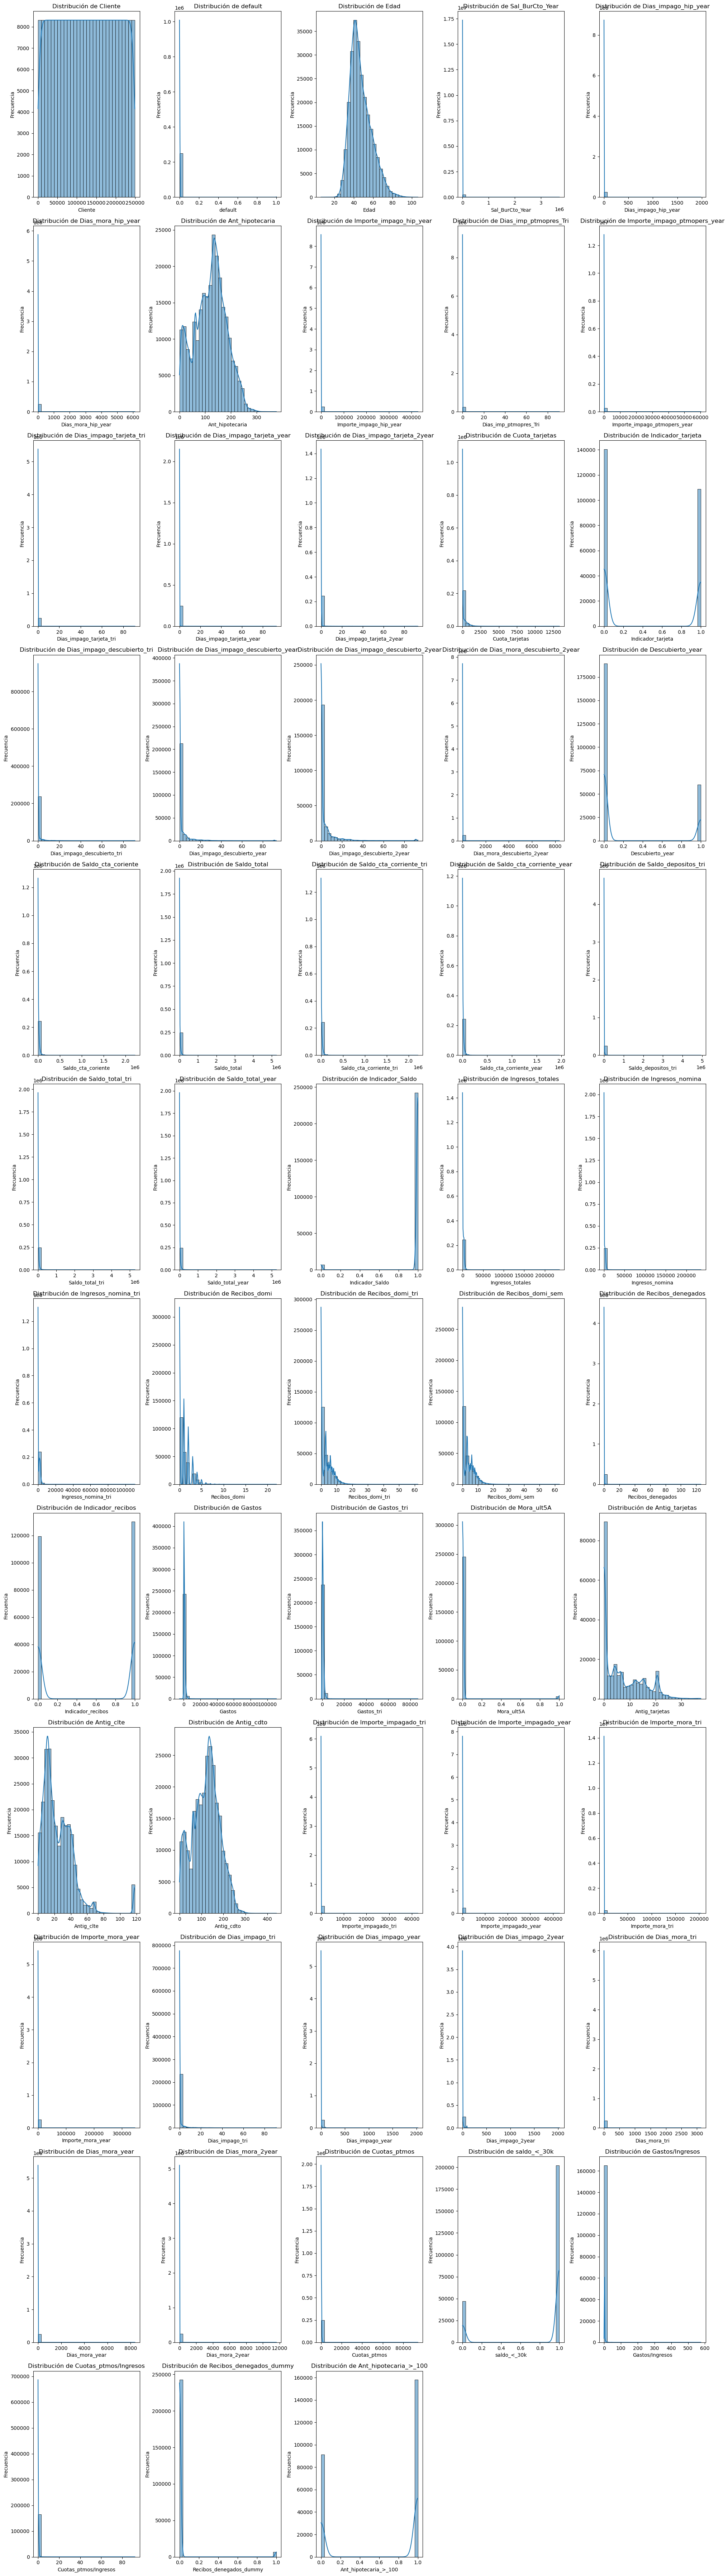

In [11]:
# Estadísticos descriptivos de las variables continuas
variables_continuas = df.select_dtypes(include=['int', 'float']).columns

# Número de filas y columnas para la cuadrícula
n_cols = 5
n_rows = (len(variables_continuas) // n_cols) + (len(variables_continuas) % n_cols > 0)

# Crear la figura y los subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))

# Aplanar la matriz de ejes para facilitar el acceso
axes = axes.flatten()

# Crear los histogramas
for i, var in enumerate(variables_continuas):
    sns.histplot(df[var], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')

# Eliminar los ejes adicionales si hay menos variables que subgráficos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout para evitar solapamientos
plt.tight_layout()
plt.show()

Outliers en Cliente: 0
Outliers en default: 388
Outliers en Edad: 3607
Outliers en Sal_BurCto_Year: 6512
Outliers en Dias_impago_hip_year: 22830
Outliers en Dias_mora_hip_year: 382
Outliers en Ant_hipotecaria: 199
Outliers en Importe_impago_hip_year: 22715
Outliers en Dias_imp_ptmopres_Tri: 80
Outliers en Importe_impago_ptmopers_year: 596
Outliers en Dias_impago_tarjeta_tri: 617
Outliers en Dias_impago_tarjeta_year: 2698
Outliers en Dias_impago_tarjeta_2year: 4592
Outliers en Cuota_tarjetas: 47303
Outliers en Indicador_tarjeta: 0
Outliers en Dias_impago_descubierto_tri: 24021
Outliers en Dias_impago_descubierto_year: 60129
Outliers en Dias_impago_descubierto_2year: 30732
Outliers en Dias_mora_descubierto_2year: 618
Outliers en Descubierto_year: 60129
Outliers en Saldo_cta_coriente: 23387
Outliers en Saldo_total: 24795
Outliers en Saldo_cta_corriente_tri: 23104
Outliers en Saldo_cta_corriente_year: 22635
Outliers en Saldo_depositos_tri: 45285
Outliers en Saldo_total_tri: 24640
Outliers 

c:\Users\Usuario\anaconda3\envs\DM_reto9\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


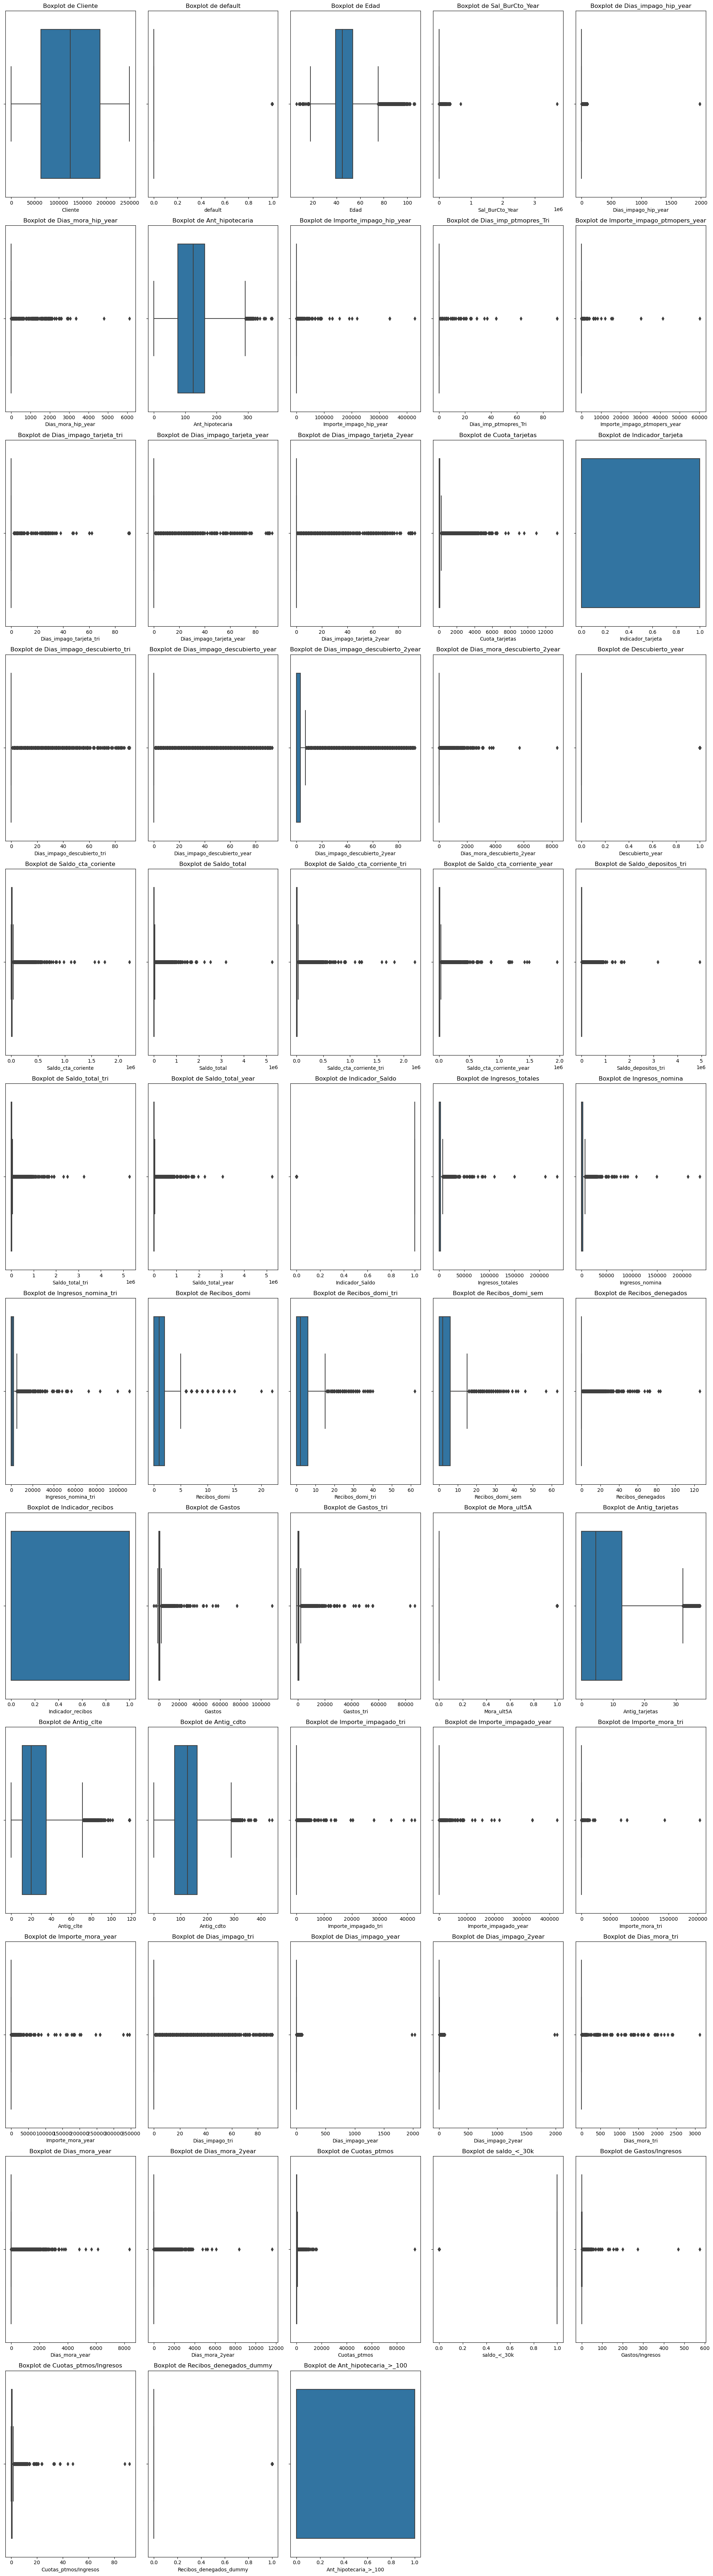

In [12]:
# Detección de outliers mediante IQR
def detectar_outliers(df, variable):
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[variable] < limite_inferior) | (df[variable] > limite_superior)]

# Número de filas y columnas para la cuadrícula
n_cols = 5
n_rows = (len(variables_continuas) // n_cols) + (len(variables_continuas) % n_cols > 0)

# Crear la figura y los subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))

# Aplanar la matriz de ejes para facilitar el acceso
axes = axes.flatten()

# Mostrar outliers y boxplots por cada variable continua
for i, var in enumerate(variables_continuas):
    outliers = detectar_outliers(df, var)
    print(f'Outliers en {var}:', outliers.shape[0])
    sns.boxplot(data=df, x=var, ax=axes[i])
    axes[i].set_title(f'Boxplot de {var}')
    axes[i].set_xlabel(var)

# Eliminar los ejes adicionales si hay menos variables que subgráficos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout para evitar solapamientos
plt.tight_layout()
plt.show()

In [13]:
# Lista para almacenar las variables significativas
variables_significativas = []

# Realizar el Test T para cada variable continua
for var in variables_continuas:
    # Filtrar los datos por las dos categorías de 'default'
    group_0 = df[df['default'] == 0][var]
    group_1 = df[df['default'] == 1][var]
    
    # Realizar el test T de Student
    t_stat, p_value = ttest_ind(group_0, group_1, nan_policy='omit')
    
    # Mostrar los resultados
    print(f"Test T para {var}:")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")
    
    # Si el valor p es menor a 0.05, se considera que hay una diferencia significativa
    if p_value < 0.05:
        print("Conclusión: Existen diferencias significativas entre las medias de las dos categorías.\n")
        variables_significativas.append(var)  # Almacenar la variable significativa
    else:
        print("Conclusión: No hay diferencias significativas entre las medias de las dos categorías.\n")

# Mostrar las variables significativas
print("Variables con diferencias significativas:")
print(variables_significativas)

# En resumen:

# Si el valor p es menor que 0.05, se considera que hay una diferencia significativa.
# Si el valor p es mayor que 0.05, no hay evidencia suficiente para afirmar que las medias sean diferentes, por lo que no se considera significativa.
# Por lo tanto, el criterio de selección es: quedarse con las variables cuyo valor p sea menor que 0.05.

Test T para Cliente:
T-statistic: -34.170, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para default:
T-statistic: -inf, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Edad:
T-statistic: -5.558, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Sal_BurCto_Year:
T-statistic: -2.464, P-value: 0.014
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Dias_impago_hip_year:
T-statistic: -42.270, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Dias_mora_hip_year:
T-statistic: -17.155, P-value: 0.000
Conclusión: Existen diferencias significativas entre las medias de las dos categorías.

Test T para Ant_hipotecaria:
T-statistic: -2.474, P-value: 0.013
Conclusión: Existen diferencias sig

In [28]:
# Correlación entre variables --> TODAS

# Umbral de correlación
umbral = 0.7  # Puedes ajustar este valor según lo que consideres relevante

# Calcular la matriz de correlaciones
corr_matrix = df.corr()

# Enmascarar la diagonal (correlaciones de una variable consigo misma)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Filtrar las correlaciones por el umbral (superior a +0.7 o -0.7)
filtered_corr_matrix = corr_matrix.where(np.abs(corr_matrix) > umbral)

# Eliminar la diagonal (correlaciones de una variable consigo misma) para que no se muestre
filtered_corr_matrix = filtered_corr_matrix.stack().reset_index()

# Filtrar para que solo se muestren las correlaciones por encima del umbral (sin duplicados)
filtered_corr_matrix.columns = ['Variable_1', 'Variable_2', 'Correlacion']
filtered_corr_matrix = filtered_corr_matrix[filtered_corr_matrix['Variable_1'] != filtered_corr_matrix['Variable_2']]

# Mostrar la tabla
pd.set_option('display.max_rows', None)  # Para que muestre todas las filas sin truncarlas
filtered_corr_matrix.sort_values(by='Correlacion', ascending=False).reset_index(drop=True)

,Variable_1,Variable_2,Correlacion
0,Saldo_total,Saldo_total_tri,0.994641
1,Saldo_total_tri,Saldo_total,0.994641
2,Ant_hipotecaria,Antig_cdto,0.993897
3,Antig_cdto,Ant_hipotecaria,0.993897
4,Importe_impago_hip_year,Importe_impagado_year,0.989843
5,Importe_impagado_year,Importe_impago_hip_year,0.989843
6,Saldo_cta_corriente_tri,Saldo_cta_coriente,0.984173
7,Saldo_cta_coriente,Saldo_cta_corriente_tri,0.984173
8,Saldo_total_year,Saldo_total_tri,0.982182
9,Saldo_total_tri,Saldo_total_year,0.982182


In [15]:
# Obtener las correlaciones con 'default' de la matriz de correlación --> CORRELACIONES 'DEFAULT'
default_corr = corr_matrix['default'].sort_values(ascending=False)

# Mostrar las correlaciones con 'default', excluyendo la diagonal (correlación de 'default' consigo mismo)
default_corr = default_corr[default_corr.index != 'default']

# Mostrar los resultados
default_corr

Dias_impago_descubierto_year     0.124999
Dias_impago_descubierto_2year    0.119540
Dias_impago_tri                  0.115121
Dias_impago_2year                0.112001
Dias_impago_year                 0.109373
Dias_impago_descubierto_tri      0.102896
Dias_impago_hip_year             0.084334
Mora_ult5A                       0.079127
Cliente                          0.068259
Dias_mora_2year                  0.043143
Dias_impago_tarjeta_tri          0.040390
Dias_mora_year                   0.039604
Descubierto_year                 0.037927
Dias_impago_tarjeta_year         0.036175
Recibos_denegados                0.035334
Dias_mora_hip_year               0.034330
Recibos_denegados_dummy          0.032205
Dias_impago_tarjeta_2year        0.029436
Dias_mora_tri                    0.023816
Importe_impagado_tri             0.023717
Dias_mora_descubierto_2year      0.019385
saldo_<_30k                      0.015672
Cuotas_ptmos/Ingresos            0.013827
Edad                             0

In [27]:
#  Correlación con las variables de interés (están puestas en el doc, pq son de interés)

# Lista de variables de interés
variables_interes = [
    'default', 'Edad', 'Dias_impago_hip_year', 'Dias_mora_hip_year',
    'Dias_impago_descubierto_year', 'Saldo_total',
    'Saldo_cta_corriente_year', 'Ingresos_totales', 'Gastos', 'Mora_ult5A'
]

# Filtrar el dataset solo con las variables de interés
df_filtered = df[variables_interes]

# Calcular la matriz de correlación
correlation_matrix = df_filtered.corr()

# Umbral de correlación
umbral = 0.1  # Puedes ajustar este valor según lo que consideres relevante


# Enmascarar la diagonal (correlaciones de una variable consigo misma)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Filtrar las correlaciones por el umbral (superior a +0.7 o -0.7)
filtered_corr_matrix2 = correlation_matrix.where(np.abs(correlation_matrix) > umbral)

# Eliminar la diagonal (correlaciones de una variable consigo misma) para que no se muestre
filtered_corr_matrix2 = filtered_corr_matrix2.stack().reset_index()

# Filtrar para que solo se muestren las correlaciones por encima del umbral (sin duplicados)
filtered_corr_matrix2.columns = ['Variable_1', 'Variable_2', 'Correlacion']
filtered_corr_matrix2 = filtered_corr_matrix2[filtered_corr_matrix2['Variable_1'] != filtered_corr_matrix2['Variable_2']]

# Mostrar la tabla
pd.set_option('display.max_rows', None)  # Para que muestre todas las filas sin truncarlas
filtered_corr_matrix2.sort_values(by='Correlacion', ascending=False).reset_index(drop=True)

,Variable_1,Variable_2,Correlacion
0,Saldo_cta_corriente_year,Saldo_total,0.684352
1,Saldo_total,Saldo_cta_corriente_year,0.684352
2,Dias_impago_hip_year,Dias_impago_descubierto_year,0.323623
3,Dias_impago_descubierto_year,Dias_impago_hip_year,0.323623
4,Gastos,Ingresos_totales,0.276847
5,Ingresos_totales,Gastos,0.276847
6,Mora_ult5A,Dias_impago_descubierto_year,0.272732
7,Dias_impago_descubierto_year,Mora_ult5A,0.272732
8,Dias_impago_hip_year,Dias_mora_hip_year,0.255230
9,Dias_mora_hip_year,Dias_impago_hip_year,0.255230
